In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import warnings

# Chargement des données
df = pd.read_csv("donnees_ecommerce.csv", encoding="ISO-8859-1")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Aperçu des données

In [64]:
def getDuplicateColumns(base):
    duplicateColumnNames = set()
    for x in range(base.shape[1]):
        col = base.iloc[:, x]
        for y in range(x + 1, base.shape[1]):
            otherCol = base.iloc[:, y]
            if col.equals(otherCol):
                duplicateColumnNames.add(base.columns.values[y])
    return list(duplicateColumnNames)

def stat_globale_df(base):
    stats = {
        "Indicateur": [
            "Nombre de variables",
            "Nombre d'observations",
            "Nombre de valeurs manquantes",
            "Pourcentage de valeurs manquantes",
            "Nombre de lignes dupliquées",
            "Pourcentage de lignes dupliquées",
            "Nombre de lignes entièrement vides",
            "Pourcentage de lignes vides",
            "Nombre de colonnes vides",
            "Pourcentage de colonnes vides",
            "Colonnes avec noms dupliqués",
            "Nombre de colonnes dupliquées"
        ],
        "Valeur": [
            base.shape[1],
            base.shape[0],
            base.isna().sum().sum(),
            "{:.2%}".format(base.isna().sum().sum() / base.size),
            base.duplicated().sum(),
            "{:.2%}".format(base.duplicated().sum() / len(base)),
            base.isna().all(axis=1).sum(),
            "{:.2%}".format(base.isna().all(axis=1).sum() / len(base)),
            base.isnull().all().sum(),
            "{:.2%}".format(base.isnull().all().sum() / base.shape[1]),
            base.columns.duplicated().sum(),
            len(getDuplicateColumns(base))
        ]
    }

    return pd.DataFrame(stats)


In [29]:
statistiques = stat_globale_df(df)
print(statistiques)

                            Indicateur  Valeur
0                  Nombre de variables       8
1                Nombre d'observations  541909
2         Nombre de valeurs manquantes  136534
3    Pourcentage de valeurs manquantes   3.15%
4          Nombre de lignes dupliquées    5268
5     Pourcentage de lignes dupliquées   0.97%
6   Nombre de lignes entièrement vides       0
7          Pourcentage de lignes vides   0.00%
8             Nombre de colonnes vides       0
9        Pourcentage de colonnes vides   0.00%
10        Colonnes avec noms dupliqués       0
11       Nombre de colonnes dupliquées       0


In [74]:
# Suppression des lignes entièrement vides
df = df.dropna(how='all')

# Suppression des doublons
df = df.drop_duplicates()

# Suppression des transactions sans CustomerID (non identifiables)
df = df[~df['CustomerID'].isna()]

# Suppression des valeurs manquantes 
df = df.dropna()
# Conversion 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Dimensions après nettoyage :", df.shape)
print("Valeurs manquantes restantes :", df.isnull().sum().sum())


Dimensions après nettoyage : (401604, 9)
Valeurs manquantes restantes : 0


In [79]:
df['Montant'] = df['Quantity'] * df['UnitPrice']
date_ref = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (date_ref - x.max()).days,
    'InvoiceNo': 'nunique',
    'Montant': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [80]:
# 2. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

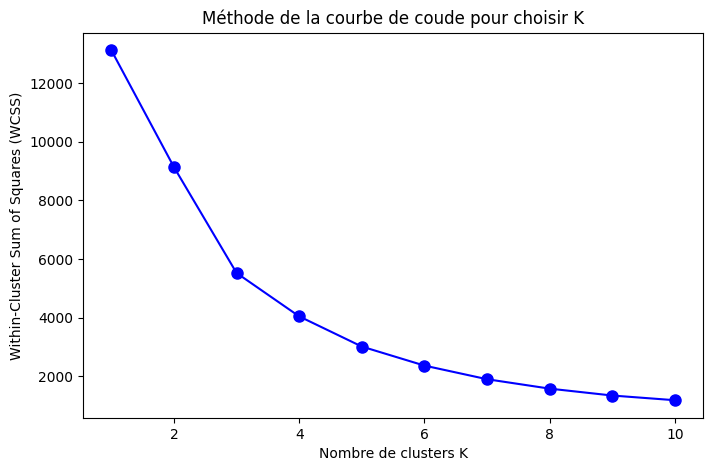

In [81]:
# 3. Courbe de coude
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-', markersize=8)
plt.xlabel('Nombre de clusters K')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Méthode de la courbe de coude pour choisir K')
plt.show()

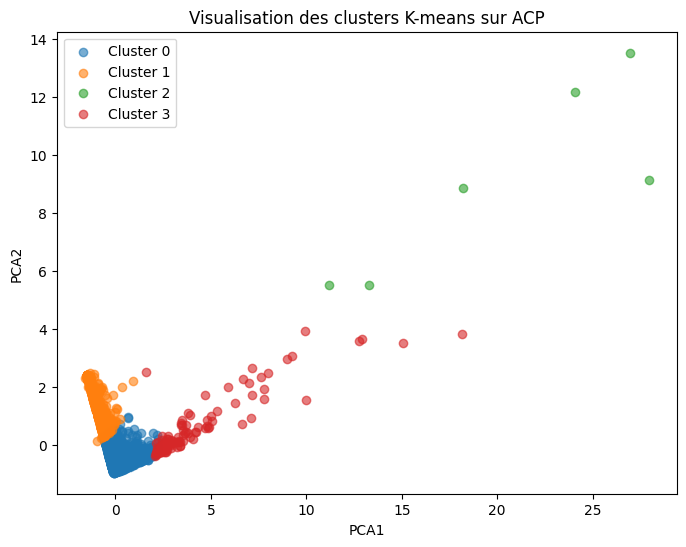

In [83]:
# 4. Choix de K (exemple K=4) et clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
rfm['Cluster'] = labels

# 5. ACP pour projection 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]
# Visualisation des clusters dans le plan PCA
plt.figure(figsize=(8,6))
for cluster in range(k):
    subset = rfm[rfm['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', alpha=0.6)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Visualisation des clusters K-means sur ACP')
plt.legend()
plt.show()

In [84]:

# 6. Résumé profil client par cluster 
profil_cluster = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'CustomerID': 'count'
})

profil_cluster.columns = ['_'.join(col) for col in profil_cluster.columns]
print("\nProfil moyen des clusters :\n")
print(profil_cluster)



Profil moyen des clusters :

         Recency_mean  Recency_std  Frequency_mean  Frequency_std  \
Cluster                                                             
0           41.606500    35.774874        4.802461       4.357173   
1          247.951242    67.527011        1.805888       1.428480   
2            7.666667     8.869423       89.000000      79.759639   
3            9.181818    29.240911       40.672727      29.293237   

         Monetary_mean  Monetary_std  CustomerID_count  
Cluster                                                 
0          1472.653251   1807.374173              3169  
1           451.802991    903.121224              1087  
2        182108.075000  71631.203349                 6  
3         18435.663364  16747.775094               110  


In [86]:
# --- Etude de la stabilité à l’initialisation ---
silhouette_scores = []
models = []

for random_state in range(10):  # 10 initialisations différentes
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    models.append(kmeans)
    print(f"Init random_state={random_state} => silhouette_score={score:.4f}")

Init random_state=0 => silhouette_score=0.6115
Init random_state=1 => silhouette_score=0.6113
Init random_state=2 => silhouette_score=0.6115
Init random_state=3 => silhouette_score=0.6115
Init random_state=4 => silhouette_score=0.6115
Init random_state=5 => silhouette_score=0.6115
Init random_state=6 => silhouette_score=0.6115
Init random_state=7 => silhouette_score=0.6115
Init random_state=8 => silhouette_score=0.6115
Init random_state=9 => silhouette_score=0.6115


In [87]:
# --- Choix du meilleur modèle ---
best_idx = silhouette_scores.index(max(silhouette_scores))
best_kmeans = models[best_idx]
print(f"\nMeilleur modèle sélectionné avec random_state={best_idx} (silhouette={silhouette_scores[best_idx]:.4f})")


Meilleur modèle sélectionné avec random_state=0 (silhouette=0.6115)


## Partie Contrat de maintenance

In [92]:
from datetime import datetime as dt, timedelta
# Vérification de la période couverte
print("Date de la première commande : ", df.InvoiceDate.min())
print("Date de la dernière commande : ", df.InvoiceDate.max())

Date de la première commande :  2010-12-01 08:26:00
Date de la dernière commande :  2011-12-09 12:50:00


## Echantillonnage des données¶

In [90]:
def echantillonnage(df, n, pas=30, duree=180):
    date_min = df['InvoiceDate'].min()
    date_min = date_min + timedelta(days=pas * (n-1))
    date_max = date_min + timedelta(days=duree)
    
    sample_df = df[(df['InvoiceDate'] >= date_min) & 
                   (df['InvoiceDate'] < date_max)]
    
    print(f'Taille échantillon {n} : {sample_df.shape}')
    print(f'Données du {sample_df["InvoiceDate"].min()} au {sample_df["InvoiceDate"].max()}\n')
    
    return sample_df.copy()

In [93]:
# Création de plusieurs échantillons 
B0 = echantillonnage(df, 1)
B1 = echantillonnage(df, 2)
B2 = echantillonnage(df, 3)
B3 = echantillonnage(df, 4)
B4 = echantillonnage(df, 5)
B5 = echantillonnage(df, 6)
B6 = echantillonnage(df, 7)
B7 = echantillonnage(df, 8)
B8 = echantillonnage(df, 9)

Taille échantillon 1 : (146419, 10)
Données du 2010-12-01 08:26:00 au 2011-05-29 15:44:00

Taille échantillon 2 : (146764, 10)
Données du 2011-01-04 10:00:00 au 2011-06-28 17:28:00

Taille échantillon 3 : (153677, 10)
Données du 2011-01-30 10:19:00 au 2011-07-28 19:46:00

Taille échantillon 4 : (159014, 10)
Données du 2011-03-01 08:30:00 au 2011-08-26 15:44:00

Taille échantillon 5 : (168184, 10)
Données du 2011-03-31 09:07:00 au 2011-09-26 17:20:00

Taille échantillon 6 : (192938, 10)
Données du 2011-05-01 10:51:00 au 2011-10-26 17:00:00

Taille échantillon 7 : (227872, 10)
Données du 2011-05-31 08:03:00 au 2011-11-25 17:27:00

Taille échantillon 8 : (228486, 10)
Données du 2011-06-29 08:58:00 au 2011-12-09 12:50:00

Taille échantillon 9 : (201640, 10)
Données du 2011-07-29 08:29:00 au 2011-12-09 12:50:00



## Préparation des données pour le clustering

In [94]:
def prepare_data(df):
    # Calcul du montant total par ligne
    df['Montant'] = df['Quantity'] * df['UnitPrice']
    
    # Dernière date dans le dataset
    derniere_date = df['InvoiceDate'].max() + timedelta(days=1)
    
    # Agrégation par client
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (derniere_date - x.max()).days,  
        'InvoiceNo': 'nunique',                                   
        'Montant': 'sum'                                          
    }).rename(columns={'InvoiceDate': 'Recence', 
                       'InvoiceNo': 'Frequence', 
                       'Montant': 'MontantTotal'})
    
    return rfm

In [95]:
# Préparation des données pour chaque échantillon
B0_clean = prepare_data(B0)
B1_clean = prepare_data(B1)
B2_clean = prepare_data(B2)
B3_clean = prepare_data(B3)
B4_clean = prepare_data(B4)
B5_clean = prepare_data(B5)
B6_clean = prepare_data(B6)
B7_clean = prepare_data(B7)
B8_clean = prepare_data(B8)

In [97]:
# Affichage données préparées
B0_clean.head(5)

,Recence,Frequence,MontantTotal
CustomerID,,,
12346.0,132,2,0.00
12347.0,53,3,1823.43
12348.0,55,3,1487.24
12350.0,116,1,334.40
12352.0,68,8,601.18


## Baseline - Premier modèle de clustering

In [98]:
# Normalisation des données
scaler = StandardScaler()
B0_scaled = scaler.fit_transform(B0_clean)

# Création et entraînement du modèle KMeans
model0 = KMeans(n_clusters=4, random_state=0)
model0.fit(B0_scaled)

KMeans(n_clusters=4, random_state=0)

## Entraînement des autres modèles

In [111]:
from sklearn import metrics
def entrainer_modele(data, modele_reference):
  
    # Normalisation
    data_scaled = scaler.transform(data)
    
    # Entraînement du nouveau modèle
    nouveau_modele = KMeans(n_clusters=4, random_state=0)
    nouveau_modele.fit(data_scaled)
    
    # Prédictions
    labels_ref = modele_reference.predict(scaler.transform(data))
    labels_nouv = nouveau_modele.labels_
    
    # Calcul de l'Adjusted Rand Index
    ari = metrics.adjusted_rand_score(labels_ref, labels_nouv)
    print(f"ARI: {ari:.4f}")
    
    return ari

In [112]:
# Scores ARI arrondis
[round(score, 4) for score in ARI_scores]

[0.6017, 0.6582, 0.8537, 0.0944, 0.7071, 0.6476, 0.3083, 0.1276]

In [108]:

# Liste des échantillons nettoyés
echantillons = [B1_clean, B2_clean, B3_clean, B4_clean, 
                B5_clean, B6_clean, B7_clean, B8_clean]

# Entraînement et comparaison pour chaque échantillon
ARI_scores = []
for echantillon in echantillons:
    ARI_scores.append(entrainer_modele(echantillon, model0))

ARI: 0.6017
ARI: 0.6582
ARI: 0.8537
ARI: 0.0944
ARI: 0.7071
ARI: 0.6476
ARI: 0.3083
ARI: 0.1276


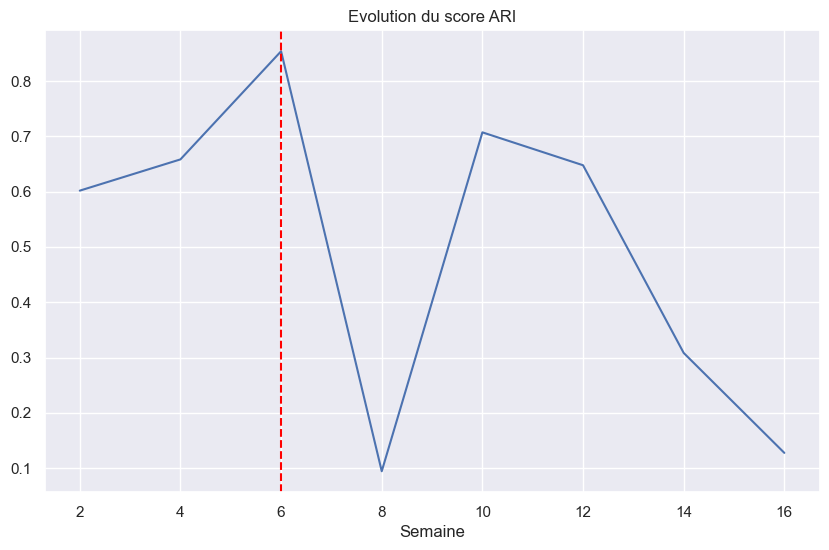

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize' : (10,6)})

# liste des score
ARI_scores=[0.6017, 0.6582, 0.8537, 0.0944, 0.7071, 0.6476, 0.3083, 0.1276]

# tracé de la courbe
ax=sns.lineplot(x=range(2, 18, 2), y=ARI_scores)

ax.axvline(6, c='red', ls='--')
plt.xticks(range(2, 18, 2))

ax.set(title='Evolution du score ARI')
ax.set_xlabel('Semaine')

plt.show()
